In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [6]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [12]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [14]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [16]:
colunas_standard_scaler = ["longitude", "latitude", "housing_median_age"]

colunas_power_transformer = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard_scaler)

colunas_power_transformer

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [18]:
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
    ],
    remainder="passthrough",
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler", RobustScaler(), colunas_robust_scaler),
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("scaler", StandardScaler(), colunas_standard_scaler),
        ("power_transformer", PowerTransformer(), colunas_power_transformer)
    ],
)

In [20]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [22]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [24]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [26]:
param_grid = {
    "regressor__preprocessor": [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [28]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [52]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsoledade

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housi...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [34]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [54]:
grid_search.best_score_

-54425.39317348588

In [38]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler__latitude,-1.074078
robust_scaler__longitude,-1.060816
one_hot__ocean_proximity_INLAND,-0.449655
robust_scaler__population_per_household,-0.232883
one_hot__ocean_proximity_NEAR BAY,-0.200334
robust_scaler__total_rooms,-0.098319
robust_scaler__total_bedrooms,-0.078951
one_hot__ocean_proximity_NEAR OCEAN,-0.057717
robust_scaler__population,-0.033034
ordinal_encoder__median_income_cat,0.033812


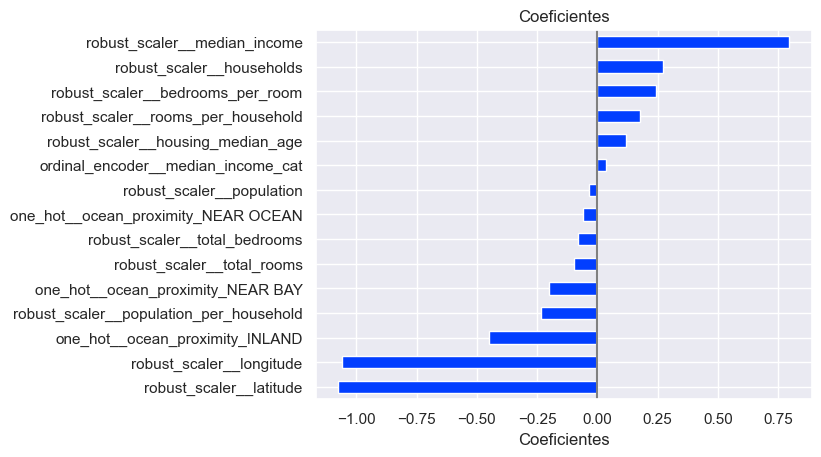

In [40]:
plot_coeficientes(coefs)

In [56]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.008782,0.001455,-0.000081,-77516.042766,-96239.705692,0.010237
1,DummyRegressor,0.001173,0.001266,-0.000146,-75787.787194,-95217.629397,0.002439
2,DummyRegressor,0.00108,0.00098,-0.001737,-76753.598961,-96253.253947,0.00206
3,DummyRegressor,0.000796,0.000931,-0.000101,-76837.804811,-95983.885799,0.001727
4,DummyRegressor,0.000806,0.000925,-0.000114,-76617.245449,-96182.764729,0.001731
5,LinearRegression,0.014474,0.020426,0.682162,-39855.690921,-54254.958115,0.0349
6,LinearRegression,0.027836,0.010889,0.66999,-40272.565406,-54695.230224,0.038725
7,LinearRegression,0.009143,0.006674,0.649247,-42178.059246,-56955.988686,0.015817
8,LinearRegression,0.015906,0.002956,0.669873,-40806.492452,-55146.31876,0.018862
9,LinearRegression,0.008003,0.002654,0.669023,-40788.496555,-55331.351171,0.010657


In [44]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002842,0.002687,-0.000436,-76702.495836,-95975.447913,0.005528
LinearRegression,0.012663,0.006519,0.668059,-40780.260916,-55276.769391,0.019182
LinearRegression_grid_search,0.031472,0.005933,0.678276,-38678.016956,-54415.268488,0.037405


In [46]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002842,0.002687,-0.000436,-76702.495836,-95975.447913,0.005528
LinearRegression,0.012663,0.006519,0.668059,-40780.260916,-55276.769391,0.019182
LinearRegression_grid_search,0.031472,0.005933,0.678276,-38678.016956,-54415.268488,0.037405


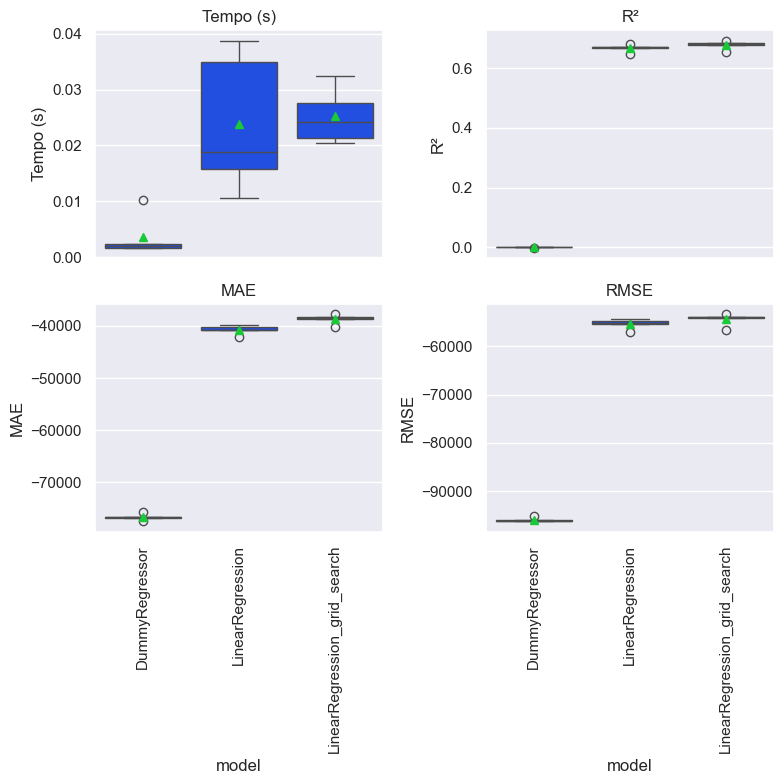

In [68]:
plot_comparar_metricas_modelos(df_resultados)

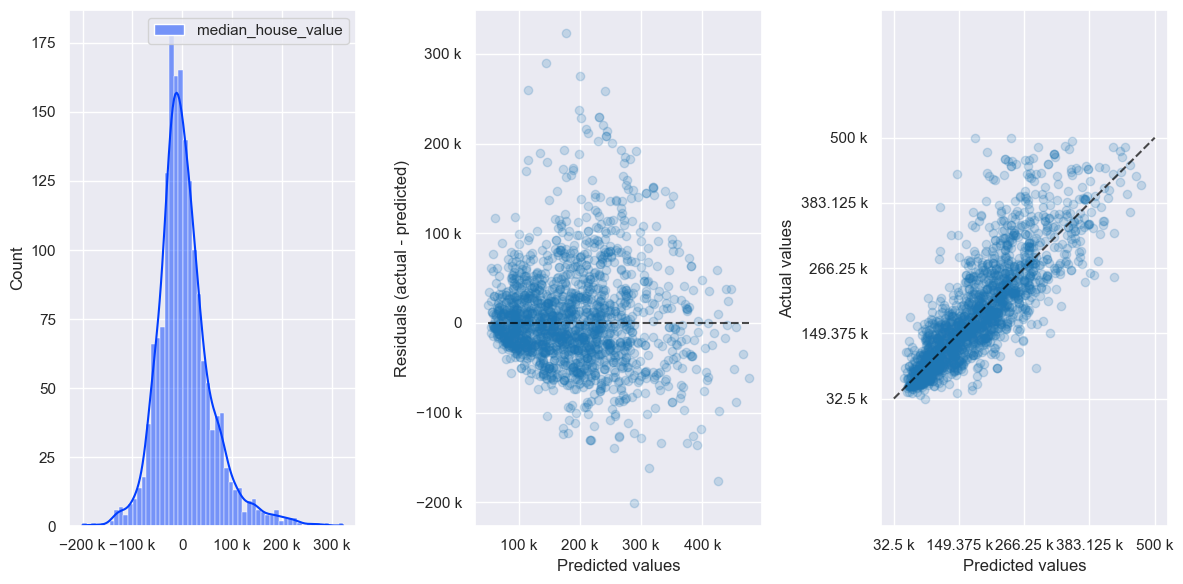

In [70]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)